## Multivariate Input ,Univariate Output LSTM ,Single Step

In [1]:
# import libary need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
def multivariate_univariate_single_step(sequence,window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix,:-1], sequence[end_ix-1,-1]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

## Hyperparameter

In [3]:
split_ratio = 0.70
num_epochs = 2
window_size = 4
n_step = 1
learning_rate = 0.01
#seed
torch.manual_seed(123)

## Synthetic data

In [4]:
in_seq1 = np.array([x for x in range(0, 300, 10)])
in_seq2 = np.array([x for x in range(5, 305, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])


# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

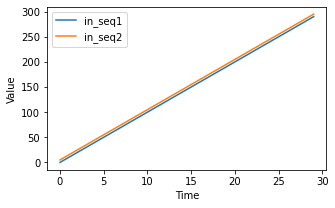

In [5]:
plt.figure(figsize=(5,3))
plt.plot(in_seq1, label="in_seq1")
plt.plot(in_seq2, label="in_seq2")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

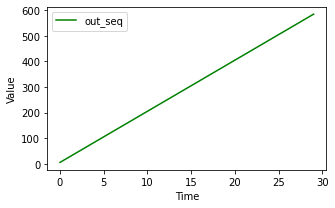

In [6]:
plt.figure(figsize=(5,3))
plt.plot(out_seq, label="out_seq",color='g')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [7]:
split_data = round(len(dataset)*split_ratio)
split_data

21

In [8]:
#split data by indexing 
train_data = dataset[:split_data]
test_data = dataset[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(21, 3)
test_data_shape
(9, 3)


## Data Normalization

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))
test_data_normalized = scaler.fit_transform(test_data.reshape(-1, 1))

In [10]:
#transform after scaling
train_data_normalized = train_data_normalized.reshape(train_data.shape[0],train_data.shape[1])
print("test_data_normalized"+str(train_data_normalized.shape))

test_data_normalized = test_data_normalized.reshape(test_data.shape[0],test_data.shape[1])
print("test_data_normalized"+str(test_data_normalized.shape))

test_data_normalized(21, 3)
test_data_normalized(9, 3)


## Data Sequencing 

In [11]:
trainX ,trainY =  multivariate_univariate_single_step(train_data_normalized,window_size)
testX , testY = multivariate_univariate_single_step(test_data_normalized,window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(18, 4, 2) trainY shape:(18,)

testX shape:(6, 4, 2) testY shape:(6,)


## Data Transform

In [12]:
# make training and test sets in torch
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)

In [13]:
# 3D Data Preparation
trainX = torch.reshape(trainX,(trainX.shape[0],trainX.shape[1],trainX.shape[2]))
trainY = torch.reshape(trainY,(trainY.shape[0],n_step))
testX = torch.reshape(testX,(testX.shape[0],trainX.shape[1],trainX.shape[2]))
testY = torch.reshape(testY,(testY.shape[0],n_step))

In [14]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset,batch_size=1,shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset,batch_size=1,shuffle=False)

# Vanila LSTM

In [15]:
class LSTM(nn.Module):

        def __init__(self, n_feature, hidden_dim, num_layers, output_dim):
            super(LSTM, self).__init__()

            self.n_feature = n_feature
            # Hidden dimensions
            self.hidden_dim = hidden_dim

            # Number of hidden layers
            self.num_layers = num_layers

            # Building your LSTM
            # batch_first=True causes input/output tensors to be of shape
            # (batch_dim, seq_dim, feature_dim)
            self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True)

            # Readout layer
            self.fc = nn.Linear(hidden_dim, output_dim)


        def forward(self, x):
            # Initialize hidden state with zeros
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

            # Initialize cell state
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

            # One time step
            # We need to detach as we are doing truncated backpropagation through time (BPTT)
            # If we don't, we'll backprop all the way to the start even after going through another batch
            out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

            # Index hidden state of last time step
            # out.size() --> 100, 28, 100
            # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
            out = self.fc(out[:, -1, :])
            # out.size() --> 100, 10
            return out

## Bidirectional LSTM

In [16]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, n_feature, hidden_dim, num_layers, output_dim):
        super(BidirectionalLSTM, self).__init__()

        self.n_feature = n_feature
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True,bidirectional=True)

        # Readout layer *2 for bidirectional LSTM
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        
        return out

## Model Deployment

In [17]:
#Arguments for LSTM model
hidden_dim = 10
number_of_time_series = trainX.shape[2] 

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1

#Vanila , Stacked LSTM
# model = LSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=n_step, num_layers=num_layers)

#Bidirectional LSTM
model = BidirectionalLSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=n_step, num_layers=num_layers)

In [18]:
#loss function 
loss_fn = torch.nn.MSELoss()

#optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training 

In [19]:
def training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        # Initialise hidden state
    #     Don't do this if you want your LSTM to be stateful
    #     model.hidden = model.init_hidden()
        running_loss_train = 0
        running_loss_valid = 0
        for _,(train_X,train_Y) in enumerate(train_iter):


            # Forward pass
            y_train_pred = model(train_X)

            #Reshape to perform MSE 
            y_train_pred=torch.reshape(y_train_pred,(train_Y.shape[0],train_Y.shape[1]))

            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()

            running_loss_train += loss_train.item()

        epoch_loss_train = running_loss_train /len(train_X)
        train_loss[t] = epoch_loss_train





        with torch.no_grad():
            for _,(test_X,test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                #Reshape to perform MSE 
                y_test_pred=torch.reshape(y_test_pred,(test_Y.shape[0],test_Y.shape[1]))
                loss_test = loss_fn(y_test_pred, test_Y)
                running_loss_valid += loss_test.item()

        epoch_loss_test =running_loss_valid /len(test_X)

        val_loss[t] = epoch_loss_test
    
    return train_loss,val_loss
            
        

In [20]:
train_loss,val_loss = training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model)

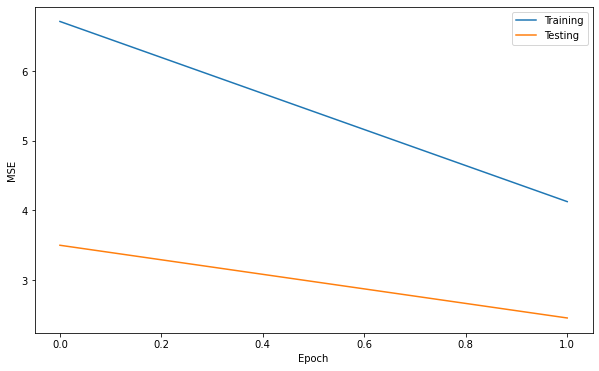

In [21]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Inference

In [22]:
# # make predictions
y_train_prediction = model(trainX)
y_test_prediction = model(testX)

# Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [23]:
#Invert predictions
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [24]:
print("y-test\t\t\t\ty-predict")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

y-test				y-predict
[484.99997]		[415.09433]
[505.]		[416.7037]
[525.]		[418.33127]
[545.]		[419.9756]
[565.]		[421.63513]
[585.]		[423.3083]


In [25]:
print(f"y_test_shape : {y_test.shape}")
print(f"y_test_pred_shape : {y_test_prediction.shape}")

y_test_shape : (6, 1)
y_test_pred_shape : (6, 1)


In [26]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 87.94 RMSE
Test Score: 119.99 RMSE


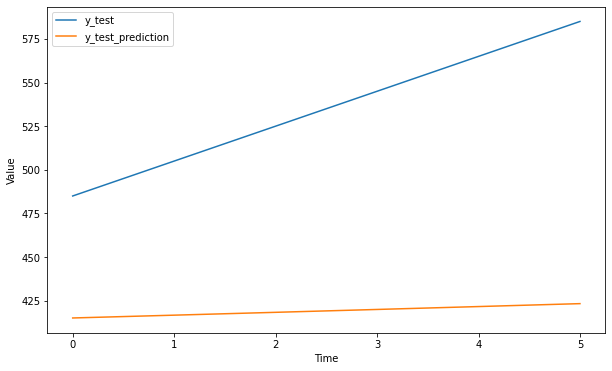

In [101]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label="y_test")
plt.plot(y_test_prediction, label="y_test_prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

## Exercise for Multivariate (Solution)
Predict total number of demand of orders (Target Total Orders) \
Data Source : https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Daily%20Demand%20Forecasting%20Orders

In [102]:
demand = pd.read_csv(r"..\datasets\others\Daily_Demand_Forecasting_Orders.csv",sep=';')
demand.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [29]:
len(demand)

60

In [30]:
demand.index.name = "Day"
demand = demand.reindex(index=range(1,len(demand)))
demand.iloc[0:5]

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
Day,,,,,,,,,,,,,
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
5,2,4,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364


In [31]:
demand_slice = demand.iloc[:,2::]
demand_slice.iloc[1:5,:]

,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
Day,,,,,,,,,,,
2,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
5,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364


In [32]:
demand_value = demand_slice.values
demand_value.shape

(59, 11)

In [82]:
#Hyperameter
split_ratio_demand = 0.70
num_epochs_demand  = 200
window_size_demand = 4
n_step_demand = 1
learning_rate_demand = 0.01
batch_size_demand = 2
#seed
torch.manual_seed(123)

In [83]:
split_data_demand = round(len(dataset)*split_ratio)
split_data_demand

21

In [84]:
#split data by indexing 
train_data_demand = demand_value[:-split_data_demand]
test_data_demand = demand_value[-split_data_demand:]
print("train_data_shape")
print(train_data_demand.shape)
print("test_data_shape")
print(test_data_demand.shape)

train_data_shape
(38, 11)
test_data_shape
(21, 11)


In [85]:
# Data Normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized_demand  = scaler.fit_transform(train_data_demand.reshape(-1, 1))
test_data_normalized_demand = scaler.fit_transform(test_data_demand.reshape(-1, 1))

In [86]:
# Transform after scaling
train_data_normalized_demand = train_data_normalized_demand .reshape(train_data_demand.shape[0],train_data_demand.shape[1])
print("test_data_normalized"+str(train_data_normalized_demand.shape))

test_data_normalized_demand = test_data_normalized_demand.reshape(test_data_demand.shape[0],test_data_demand.shape[1])
print("test_data_normalized"+str(test_data_normalized_demand.shape))


test_data_normalized(38, 11)
test_data_normalized(21, 11)


In [87]:
# Data Seqeuncing

trainX_demand ,trainY_demand =  multivariate_univariate_single_step(train_data_normalized_demand,window_size_demand)
testX_demand , testY_demand = multivariate_univariate_single_step(test_data_normalized_demand,window_size_demand)
print(f"trainX_demand shape:{trainX_demand.shape} trainY_demand shape:{trainY_demand.shape}\n")
print(f"testX_demand shape:{testX_demand.shape} testX_demand shape:{testX_demand.shape}")

trainX_demand shape:(35, 4, 10) trainY_demand shape:(35,)

testX_demand shape:(18, 4, 10) testX_demand shape:(18, 4, 10)


In [88]:
#  Data Transform

# make training and test sets in torch
trainX_demand = torch.from_numpy(trainX_demand).type(torch.Tensor)
trainY_demand = torch.from_numpy(trainY_demand).type(torch.Tensor)
testX_demand = torch.from_numpy(testX_demand).type(torch.Tensor)
testY_demand = torch.from_numpy(testY_demand).type(torch.Tensor)

#3D Data Preparation
trainX_demand = torch.reshape(trainX_demand,(trainX_demand.shape[0],trainX_demand.shape[1],trainX_demand.shape[2]))
trainY_demand = torch.reshape(trainY_demand,(trainY_demand.shape[0],n_step_demand))
testX_demand = torch.reshape(testX_demand,(testX_demand.shape[0],trainX_demand.shape[1],trainX_demand.shape[2]))
testY_demand = torch.reshape(testY_demand,(testY_demand.shape[0],n_step_demand))

In [89]:
print(f"trainX_demand shape : {trainX_demand.shape}")
print(f"trainY_demand shape : {trainY_demand.shape}")
print(f"testX_demand shape  : {testX_demand.shape}")
print(f"testY_demand_demand shape : {testY_demand.shape}")

trainX_demand shape : torch.Size([35, 4, 10])
trainY_demand shape : torch.Size([35, 1])
testX_demand shape  : torch.Size([18, 4, 10])
testY_demand_demand shape : torch.Size([18, 1])


In [90]:
# Create Iterator
train_dataset_demand = TensorDataset(trainX_demand, trainY_demand)
train_iter_demand = DataLoader(train_dataset_demand,batch_size=batch_size_demand,shuffle=False)

test_dataset_demand = TensorDataset(testX_demand, testY_demand)
test_iter_demand = DataLoader(test_dataset_demand,batch_size=batch_size_demand,shuffle=False)

In [91]:
# Deploy Model 

#Arguments for LSTM model
hidden_dim_demand = 10
number_of_time_series_demand = trainX_demand.shape[2] 

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers_demand = 1

#Vanila , Stacked LSTM
model_demand = LSTM(n_feature=number_of_time_series_demand, hidden_dim=hidden_dim_demand, output_dim=n_step_demand, num_layers=num_layers_demand)

#Bidirectional LSTM
# model_demand = BidirectionalLSTM(n_feature=number_of_time_series_demand, hidden_dim=hidden_dim_demand, output_dim=n_step_demand, num_layers=num_layers_demand)

In [92]:
#loss function 
loss_fn_demand = torch.nn.MSELoss()

#optimiser
optimiser_demand = torch.optim.Adam(model_demand.parameters(), lr=learning_rate_demand)

In [93]:
train_loss_demand,val_loss_demand = training(num_epochs_demand,train_iter_demand,test_iter_demand,
                                           optimiser = optimiser_demand,
                                           loss_fn = loss_fn_demand,
                                            model=model_demand)

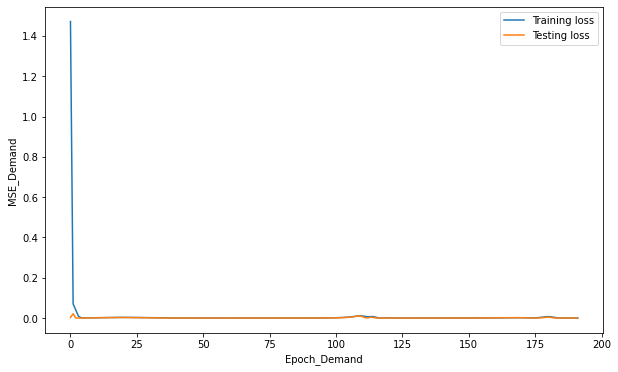

In [94]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_demand, label="Training loss")
plt.plot(val_loss_demand, label="Testing loss")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
plt.legend()
plt.show()

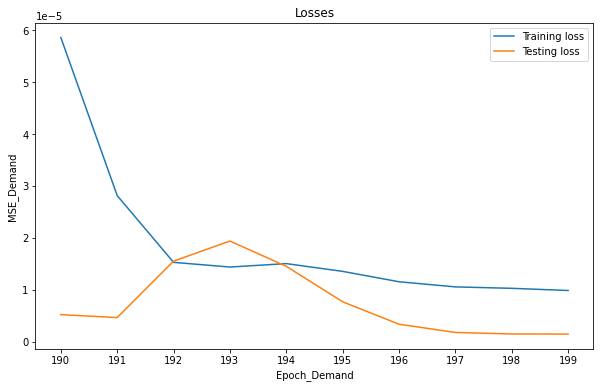

In [81]:
# Zoom in by fill in start_epoch and end_epoch
start_epoch = 190
end_epoch = 200
plt.figure(figsize=(10,6))
plt.plot(train_loss_demand[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss_demand[start_epoch:end_epoch], label="Testing loss")
plt.title("Losses")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()
plt.show()

In [95]:
# Inference 

y_train_prediction_demand = model_demand(trainX_demand)
y_test_prediction_demand = model_demand(testX_demand)

# Reshape to original data
y_train_prediction_demand = torch.reshape(y_train_prediction_demand,(y_train_prediction_demand.shape[0],y_train_prediction_demand.shape[1]))
trainY_demand = torch.reshape(trainY_demand,(trainY_demand.shape[0],trainY_demand.shape[1]))
y_test_prediction_demand = torch.reshape(y_test_prediction_demand,(y_test_prediction_demand.shape[0],y_test_prediction_demand.shape[1]))
testY_demand = torch.reshape(testY_demand,(testY_demand.shape[0],testY_demand.shape[1]))

In [96]:
#Invert predictions
y_train_prediction_demand = scaler.inverse_transform(y_train_prediction_demand.detach().numpy())
y_train_demand = scaler.inverse_transform(trainY_demand.detach().numpy())
y_test_prediction_demand = scaler.inverse_transform(y_test_prediction_demand.detach().numpy())
y_test_demand = scaler.inverse_transform(testY_demand.detach().numpy())

In [97]:
print("y-test_demand\t\t\t\ty-predict_demand")
for i in range(len(y_test_prediction_demand)):
    print(f"{y_test_demand[i]}\t\t{y_test_prediction_demand[i]}")

y-test_demand				y-predict_demand
[234.50491]		[157.21344]
[234.7216]		[173.7622]
[230.06537]		[176.01978]
[357.39624]		[246.06488]
[259.24747]		[127.734024]
[244.23564]		[182.65643]
[402.6081]		[150.23917]
[255.05988]		[212.77078]
[342.60614]		[295.72635]
[268.64056]		[198.95828]
[188.6027]		[138.39197]
[202.02213]		[153.19214]
[213.5065]		[173.76726]
[316.85074]		[265.01233]
[286.41388]		[228.45786]
[303.4464]		[337.05295]
[304.9481]		[306.43466]
[331.89783]		[295.73138]


In [98]:
print(f"y_test_demand_shape : {y_test_demand.shape}")
print(f"y_test_demand_pred_shape : {y_test_prediction_demand.shape}")

y_test_demand_shape : (18, 1)
y_test_demand_pred_shape : (18, 1)


In [99]:
# calculate root mean squared error
trainScore_demand = math.sqrt(mean_squared_error(y_train_demand[:,0], y_train_prediction_demand[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_demand))
testScore_demand = math.sqrt(mean_squared_error(y_test_demand[:,0], y_test_prediction_demand[:,0]))
print('Test Score: %.2f RMSE' % (testScore_demand))

Train Score: 97.28 RMSE
Test Score: 86.15 RMSE


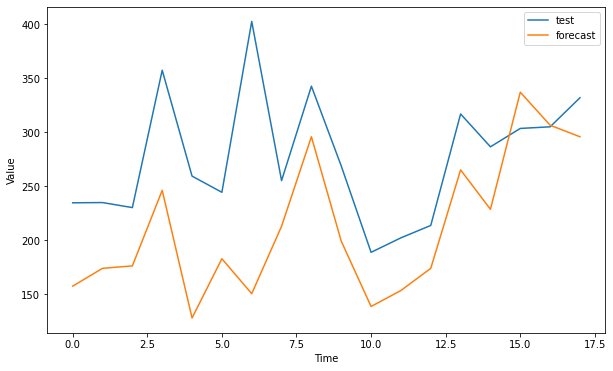

In [100]:
plt.figure(figsize=(10,6))
plt.plot(y_test_demand, label = 'test')
plt.plot(y_test_prediction_demand, label = 'forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()



## Reference
1. Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee